In [31]:
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
#這邊是先將資料載入後做統一格式的前處理
# https://www.investing.com/etfs/yuanta-p-shares-taiwan-top-50
Data=pd.read_csv("0050 ETF Stock Price History.csv") #載入csv
Data #show data

,Date,Price,Open,High,Low,Vol.,Change %
0,11/03/2023,125.45,125.00,125.60,124.70,9.13M,0.76%
1,11/02/2023,124.50,123.15,124.50,123.15,10.20M,2.26%
2,11/01/2023,121.75,122.00,122.15,121.25,4.85M,0.50%
3,10/31/2023,121.15,122.40,122.45,121.10,11.95M,-0.70%
4,10/30/2023,122.00,122.40,122.85,121.75,9.79M,-0.25%
...,...,...,...,...,...,...,...
2397,01/08/2014,57.80,57.70,57.95,57.70,7.61M,0.17%
2398,01/07/2014,57.70,57.75,57.90,57.70,13.13M,0.00%
2399,01/06/2014,57.70,57.75,57.95,57.55,14.87M,-0.26%
2400,01/03/2014,57.85,58.45,58.45,57.70,14.51M,-1.20%


In [33]:
Data['Date'] = pd.to_datetime(Data['Date']) #將原始資料的時間轉為pandas的Time Series序列
Data.index=Data.Date
Data=Data.drop(['Date'],axis=1)
Data=Data.iloc[::-1] #因為原始資料的前後順序相反了 所以將資料倒過來
Data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-01-02,58.55,58.70,58.75,58.35,10.76M,-0.26%
2014-01-03,57.85,58.45,58.45,57.70,14.51M,-1.20%
2014-01-06,57.70,57.75,57.95,57.55,14.87M,-0.26%
2014-01-07,57.70,57.75,57.90,57.70,13.13M,0.00%
2014-01-08,57.80,57.70,57.95,57.70,7.61M,0.17%
...,...,...,...,...,...,...
2023-10-30,122.00,122.40,122.85,121.75,9.79M,-0.25%
2023-10-31,121.15,122.40,122.45,121.10,11.95M,-0.70%
2023-11-01,121.75,122.00,122.15,121.25,4.85M,0.50%


<AxesSubplot:xlabel='Date'>

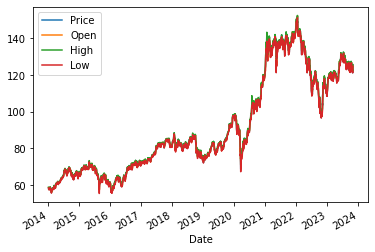

In [34]:
Data.plot()

In [35]:
#Data.Price.loc['2019'].plot()

<AxesSubplot:xlabel='Date'>

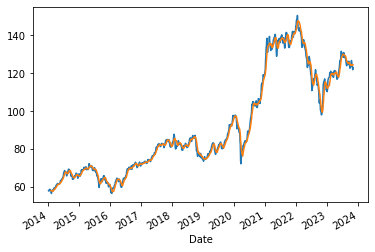

In [36]:
#要使用均線交叉策略 所以先定義兩條均線
fast=Data.Price.rolling(5).mean() #比較快的均線 參數為5
slow=Data.Price.rolling(20).mean() #比較慢的均線 參數為20
fast.plot()
slow.plot()

Date
2014-01-02    False
2014-01-03    False
2014-01-06    False
2014-01-07    False
2014-01-08    False
              ...  
2023-10-30    False
2023-10-31    False
2023-11-01    False
2023-11-02    False
2023-11-03    False
Name: Price, Length: 2402, dtype: bool

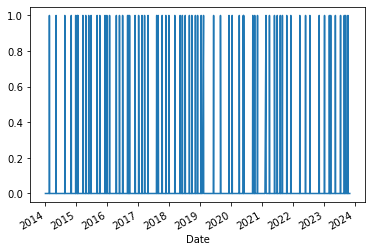

In [37]:
#這邊是使用判斷式來過濾出進場&出場時間點
Entry = (fast>slow) & (fast.shift() < slow.shift()) #定義進場:快線向上穿越慢線
Exit = (fast<slow) & (fast.shift() > slow.shift()) #定義出場:快線向下穿越慢線
Data['Entry'] = Entry
Data['Exit'] = Exit
Entry.astype(int).plot()
Entry

In [38]:
# Calculate the number of entry points
entry_count = Entry.astype(int).sum()
print("Number of Entry Points:", entry_count)

Number of Entry Points: 72


Date
2014-01-02    False
2014-01-03    False
2014-01-06    False
2014-01-07    False
2014-01-08    False
              ...  
2023-10-30    False
2023-10-31    False
2023-11-01    False
2023-11-02    False
2023-11-03    False
Name: Price, Length: 2402, dtype: bool

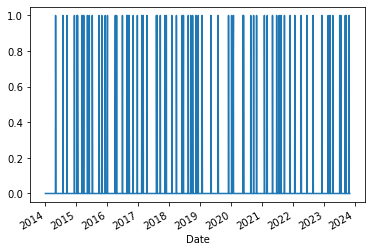

In [39]:
Exit.astype(int).plot()
Exit

In [40]:
# Calculate the number of entry points
entry_count = Exit.astype(int).sum()
print("Number of Exit Points:", entry_count)

Number of Exit Points: 72


In [41]:
# 交易模型的回測函數
def Backtesting(Data):
    # 初始化總收益
    TotalReturn = 1  # 初始總回報率設為1表示無變化
    ReturnList = []  # 用來存放每次交易的回報率的列表
    # 加入回報曲線
    TotalReturnList = []

    # 從輸入的資料中選取進場點和出場點
    EntryList = Data[Data['Entry'] == True]
    ExitList = Data[Data['Exit'] == True]

    # 迭代處理每次進場
    for i in range(len(EntryList) - 1):
        # 進場點的價格和時間
        EntryPrice = EntryList.Price.values[i]
        EntryTime = EntryList.index[i]
        # 出場點的價格和時間
        ExitPrice = ExitList.loc[EntryTime:].Price.values[0]
        ExitTime = ExitList.loc[EntryTime:].index[0]

        # 計算該次交易的回報率並乘到總回報率
        Return = (ExitPrice - EntryPrice) / EntryPrice
        TotalReturn *= (1 + Return)
        
        # 加入回報曲線
        TotalReturnList.append(TotalReturn)
        # 將該次交易的回報率加入列表
        ReturnList.append(Return)

    # 將回報率列表轉換為DataFrame格式
    ReturnList = pd.DataFrame(ReturnList)
    # 將列名設定為'Return'
    ReturnList['Return'] = ReturnList[0]
    # 刪除原來的列
    ReturnList = ReturnList.drop([0], axis=1)
    # 將索引設定為進場點的時間
    ReturnList.index = EntryList.index[0:-1]
    # 繪製回報率曲線
    ReturnList.plot()

    # 加入回報曲線圖 
    # !(第一點不是一)
    TotalReturnList = pd.DataFrame(TotalReturnList)
    TotalReturnList['Return'] = TotalReturnList[0] 
    TotalReturnList = TotalReturnList.drop([0], axis=1)
    TotalReturnList.index = EntryList.index[0:-1]
    TotalReturnList.plot()

    # 計算總回報率轉換為總獲利百分比
    TotalReturn = (TotalReturn - 1) * 100

    # 返回總獲利百分比
    return TotalReturn

63.00033185303175

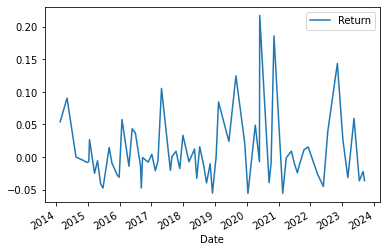

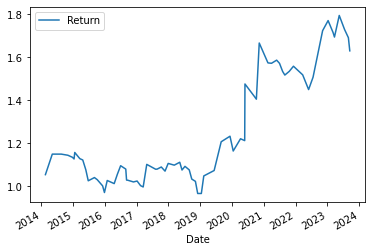

In [42]:
Backtesting(Data)

## 只回測2021-11-10以後資料

/Users/peggy/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


4.592280509903013

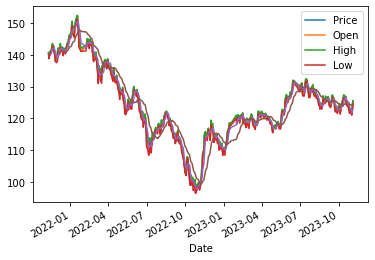

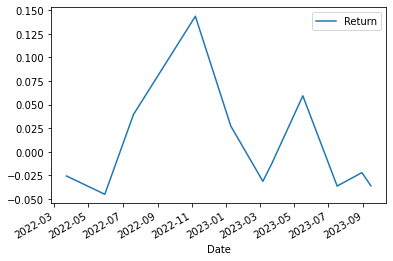

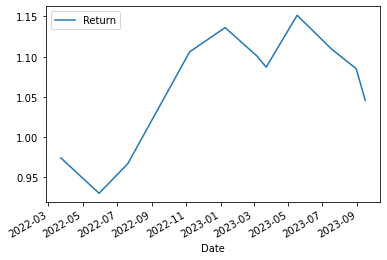

In [43]:
# 只選擇 2021-11-10 之後的資料
DataLast20 = Data.loc['2021-11-10':]

# 重新繪製圖表
DataLast20.plot()

# 重新計算均線
fast = DataLast20.Price.rolling(5).mean()
slow = DataLast20.Price.rolling(20).mean()
fast.plot()
slow.plot()

# 重新計算進場和出場點
Entry = (fast > slow) & (fast.shift() < slow.shift())
Exit = (fast < slow) & (fast.shift() > slow.shift())

# 使用 .loc 方法來避免 SettingWithCopyWarning
DataLast20.loc[:, 'Entry'] = Entry
DataLast20.loc[:, 'Exit'] = Exit

# 重新進行回測
Backtesting(DataLast20)
